# Assignment 2: TSNE Visualization (Part II)

## BoW & t-SNE

#### Data Source: 
**The preprocessing step has produced final.sqlite file after doing the data preparation & cleaning.** The review text is now devoid of punctuations, HTML markups and stop words.

#### Objective:
**To plot t-SNE plot after doing TF-IDF & Truncated SVD for dimensionality reduction.** The aim is to visualize high dimensional data and see whether there is a separation between data points.<br><br>

## Preprocessed Data Loading

In [1]:
import sqlite3
import pdb
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# using the SQLite Table to read data.
con = sqlite3.connect('./final.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
final = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con) 

print(final.head(3))

    index      Id   ProductId          UserId            ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL        shari zychinski   
1  138688  150506  0006641040  A2IW4PEEKO2R0U                  Tracy   
2  138689  150507  0006641040  A1S4A3IQ2MU7V4  sally sue "sally sue"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     0                       0  positive   939340800   
1                     1                       1  positive  1194739200   
2                     1                       1  positive  1191456000   

                                      Summary  \
0                   EVERY book is educational   
1  Love the book, miss the hard cover version   
2               chicken soup with rice months   

                                                Text  \
0  this witty little book makes my son laugh at l...   
1  I grew up reading these Sendak books, and watc...   
2  This is a fun way for children to learn their ... 

## BoW & Truncated SVD

BoW will result in a **sparse matrix with huge number of features** as it creates a feature for each unique word in the review.

If the number of features is very high, it is highly recommended to use another dimensionality reduction method (e.g. **PCA for dense data or TruncatedSVD for sparse data**) to reduce the number of dimensions to a reasonable amount (e.g. 50), **before feeding in to tsne (otherwise tsne would take lot of time**). 

In [2]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
final_counts.get_shape()

(364171, 71624)

In [3]:
# TruncatedSVD
# THere are 71624 dimensions in BoW vector. Hence TruncatedSVD is 
# used to reduce dimensins to 50, before feeding to t-SNE

from sklearn.manifold import TSNE
import pdb

num_points = 10000
# Picking the top num_points as TSNE takes a lot of time for 364K points
data_1000 = final_counts[0:num_points,:]

labels_1000 = final['Score'].head(num_points)

from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
svd = TruncatedSVD(n_components=50, n_iter=10, random_state=42)
data_1000 = svd.fit_transform(data_1000)  

print(data_1000.shape)

(10000, 50)


## t-SNE Visualization

The output of Truncated SVD is fed into t-SNE for visualization.

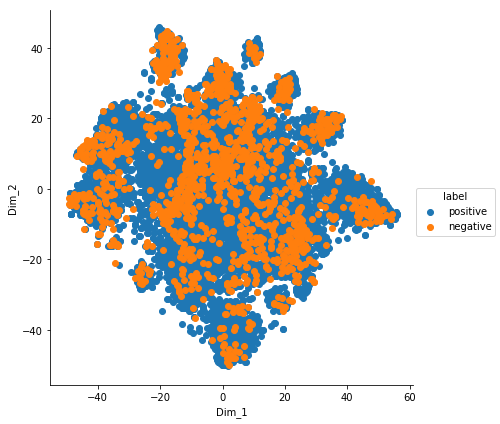

In [4]:
# TSNE Plot after dimensionality reduction

#from MulticoreTSNE import MulticoreTSNE as TSNE

#tsne = TSNE(n_jobs=1)#, n_components=2, 
#    random_state=0, perplexity = 100, n_iter = 1000)
#tsne_data = tsne.fit_transform(data_1000)

model = TSNE(n_components=2, random_state=0, perplexity = 100, n_iter = 1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_1000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(
    data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(
    plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Observations

1. Using BoW, there is **significant overlap between positive and negative** review points in t-SNE plot.
2. The separation can be **either because the underlying data has overlap or because BoW is a baseline method**. Hence, we would try next method, TF-IDF before t-SNE.